## ALICE Label Alignment

ALICE label alignment with perspective transformations.

#### Imports

In [14]:
import numpy as np
import os
import skimage.io as io
import matplotlib.pyplot as plt
from copy import deepcopy
import math
from PIL import Image, ImageOps
import cv2
from skimage import measure
from IPython.display import display, Image

#### General Functions

In [3]:
def display_cv_image(image, format='.png'):
    decoded_bytes = cv2.imencode(format, image)[1].tobytes()
    display(Image(data=decoded_bytes))

In [4]:
def removeReps(T, F):
    n = len(T)
    newT = []
    newF = []
    newT.append(T[0])
    newF.append(F[0])
    k = 0
    for i in range(1, n):
        if (T[i] != newT[k]) or (F[i] != newF[k]):
            newT.append(T[i])
            newF.append(F[i])
            k = k + 1
    return newT, newF

In [5]:
def reparam(x, y, npoints):
    # This function reparametrizes the curve to have npoints.

    tst = np.zeros((len(x), 2))
    tst[:, 0] = x
    tst[:, 1] = y

    p = tst
    dp = np.diff(p, axis=0)
    pts = np.zeros(len(dp) + 1)
    pts[1:] = np.cumsum(np.sqrt(np.sum(dp * dp, axis=1)))
    newpts = np.linspace(0, pts[-1], int(npoints))
    newx = np.interp(newpts, pts, p[:, 0])
    newy = np.interp(newpts, pts, p[:, 1])

    return newx, newy

### Alignment Tests

#### 1) Load Data

In [9]:
# Load Mask:
pth = "C:\\Users\\arian\\Downloads\\bla.npy"
mask = np.load(pth)
# Load Original Image:
img_pth = "C:\\Users\\arian\\Documents\\GitHub\\ALICE\\Data\\Original_Data\\All_Images\\train\\013612431_additional_1.JPG"
img_orig = io.imread(img_pth)

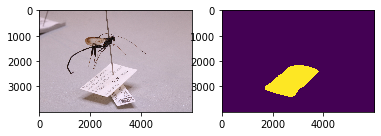

In [11]:
fig,ax = plt.subplots(1,2)
ax[0].imshow(img_orig)
ax[1].imshow(mask)

#### 2) Segment

In [12]:
# Clear Non-label Area:
inds = np.where(mask==False)
img_seg = deepcopy(img_orig)
img_seg[inds] = 1

#### 3) Find Contour and Boundary Box

In [15]:
contours = measure.find_contours(mask, 0.8)

x = contours[0][:,1]
y = contours[0][:,0]
mnx = min(x)
mxx = max(x)
mny = min(y)
mxy = max(y)

mnx_ = np.argmin(x)
mxx_ = np.argmax(x)
mny_ = np.argmin(y)
mxy_ = np.argmax(y)

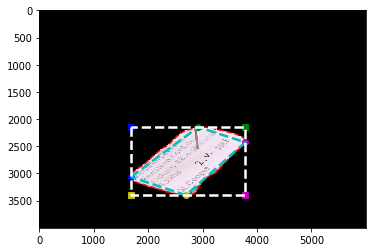

In [16]:
fig,ax = plt.subplots()
ax.imshow(img_seg)

ax.plot(contours[0][:,1],contours[0][:,0],'--r')

ax.plot(mnx,mny,'bs') # TOP LEFT
ax.plot(mnx,mxy,'ys') # BOTTOM LEFT
ax.plot(mxx,mny,'gs') # TOP RIGHT
ax.plot(mxx,mxy,'ms') # BOTTOM RIGHT


ax.plot(x[mxy_],y[mxy_],'yo') # BOTTOM LEFT
ax.plot(x[mxx_],y[mxx_],'mo') # BOTTOM RIGHT
ax.plot(x[mny_],y[mny_],'go') # TOP RIGHT
ax.plot(x[mnx_],y[mnx_],'bo') # TOP LEFT

ax.plot([x[mnx_],x[mny_],x[mxx_],x[mxy_],x[mnx_]],[y[mnx_],y[mny_],y[mxx_],y[mxy_],y[mnx_]],'--c',linewidth=2.5)

ax.plot([mnx,mnx,mxx,mxx,mnx],[mny,mxy,mxy,mny,mny],'--w',linewidth=2.5)

#### 4) Threshold Segmented Image

In [24]:
gray = cv2.cvtColor(img_seg, cv2.COLOR_BGR2GRAY)
ret,img_thresh = cv2.threshold(gray,200,255,cv2.THRESH_BINARY)

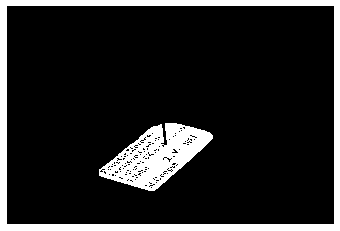

In [27]:
fig,ax = plt.subplots()
ax.imshow(img_thresh,cmap='gray')
ax.axis('off')
plt.show()

#### 5) Perspective Transformation

In [28]:
pts1 = np.float32([[x[mxx_],y[mxx_]],[x[mny_],y[mny_]],[x[mnx_],y[mnx_]],[x[mxy_],y[mxy_]]])
pts2 = np.float32([[mxx,mxy],[mxx,mny],[mnx,mny],[mnx,mxy]])

M = cv2.getPerspectiveTransform(pts1,pts2)

In [30]:
# Slightly adjust boundary:
ydim,xdim,_ = np.shape(img_seg)
epsilon_x = xdim*0.05
epsilon_y = ydim*0.05

img_warped = cv2.warpPerspective(img_seg,M,(int(mxx+epsilon_x),int(mxy+epsilon_y)))

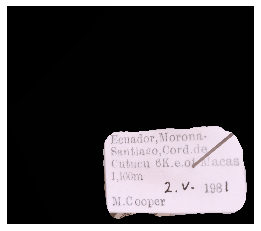

In [31]:
fig,ax = plt.subplots()
ax.imshow(img_warped,cmap='gray')
ax.axis('off')
plt.show()

#### 6) Find Contour (Around Transformed Label)

In [32]:
img_grey = cv2.cvtColor(img_warped, cv2.COLOR_BGR2GRAY)
if np.max(img_grey) > 100:
    # Assuming scale is between 0-255
    img_grey = img_grey/255

In [33]:
contours_warped = measure.find_contours(img_grey, 0.8)

# Assume contour with the greatest y-range is the label contour:
k = np.argmax([max(c[:,0])-min(c[:,0]) for c in contours_warped])

x_label = contours_warped[k][:,1]
y_label = contours_warped[k][:,0]

#### 7) Reparametrize Label Contour

In [34]:
x_label_,y_label_ = removeReps(np.round(x_label),np.round(y_label))

# Repametrize to have n points:
n = 200
x_rep,y_rep = reparam(x_label_,y_label_,n)

#### 8) Remove Background Beyond Contour

In [81]:
img_filled = deepcopy(img_warped)
a3 = np.array([np.array([x_rep,y_rep]).T], dtype=np.int32 )

# Fill background (exterior of label contour) in one colour (fill_col)
fill_col = [255,0,0]
img_filled = cv2.fillPoly( img_filled, a3, fill_col)

In [82]:
img_warped_seg = deepcopy(img_warped)
img_warped_seg[np.where(img_filled!=fill_col)[:2]] = 0

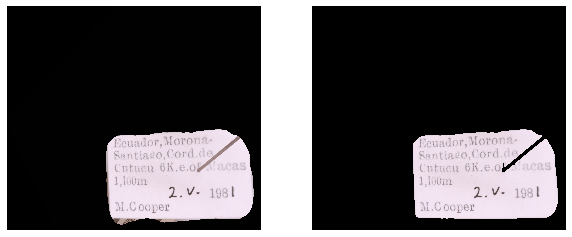

In [87]:
fig,ax = plt.subplots(1,2,figsize=(10,5))
ax[0].imshow(img_warped)
ax[1].imshow(img_warped_seg)
for i in range(0,2):
    ax[i].axis('off')

#### 9) Get Boundary Box

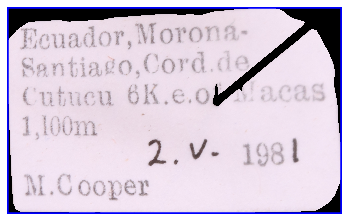

In [89]:
fig,ax = plt.subplots()
ax.imshow(img_warped_seg)

mnx2 = min(x_rep)
mxx2 = max(x_rep)
mny2 = min(y_rep)
mxy2 = max(y_rep)

ax.plot([mnx2,mnx2,mxx2,mxx2,mnx2],[mny2,mxy2,mxy2,mny2,mny2],'-b',linewidth=3.5)

ax.set_xlim([mnx2,mxx2])
ax.set_ylim([mxy2,mny2])
ax.axis('off')

plt.show()